In [2]:
# LaTeX fonts
import matplotlib
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist]);

import pandas as pd
import numpy as np
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import datetime
import time

import scipy.stats as sp
from scipy.fft import rfft, rfftfreq

from scipy import special

import imageio
import os

magic = 999

In [3]:
# Define functions
def getKurt(values,counts,threshold=5):
    # Calculates Kurtosis for a given histogram:
    # values - bin centers; 
    # counts - total instances in a bin; 
    # threshold - dimensionless value (initial 5) to filter out outliers through abs deviation (not to distort higher momentums)
    
    counts = np.array(counts/np.sum(counts))
    avg = np.dot(counts,values)

    meanabs = np.dot(counts,abs(values-avg))
    indtokeep = [i for i in range(len(values)) if abs(values[i]-avg)<meanabs*threshold]
    values = [values[i] for i in indtokeep]
    counts = [counts[i] for i in indtokeep]
    
    sumcounts = np.sum(counts)
    if sumcounts==0:
        return magic
    counts = np.array(counts/sumcounts)
    avg = np.dot(counts,values)

    std = np.sqrt(np.dot(counts, (values-avg)**2))
    if std==0:
        return magic
    avg4 = np.dot(counts, (values-avg)**4)
    kur = avg4/(std**4)-3
    
    return kur

def getSkew(values,counts,threshold=5):
    # Calculates Skewness for a given histogram:
    # values - bin centers; 
    # counts - total instances in a bin; 
    # threshold - dimensionless value (initial 5) to filter out outliers through abs deviation (not to distort higher momentums)
    
    counts = np.array(counts/np.sum(counts))
    avg = np.dot(counts,values)

    meanabs = np.dot(counts,abs(values-avg))
    indtokeep = [i for i in range(len(values)) if abs(values[i]-avg)<meanabs*threshold]
    values = [values[i] for i in indtokeep]
    counts = [counts[i] for i in indtokeep]
    
    sumcounts = np.sum(counts)
    if sumcounts==0:
        return magic
    counts = np.array(counts/sumcounts)
    avg = np.dot(counts,values)

    std = np.sqrt(np.dot(counts, (values-avg)**2))
    if std==0:
        return magic

    avg3 = np.dot(counts, (values-avg)**3)
    return avg3/(std**3)

def getAvg(values,counts,threshold=5):
    # Calculates Average for a given histogram:
    # values - bin centers; 
    # counts - total instances in a bin; 
    # threshold - dimensionless value (initial 5) to filter out outliers through abs deviation (not to distort higher momentums)
    
    counts = np.array(counts/np.sum(counts))
    avg = np.dot(counts,values)

    meanabs = np.dot(counts,abs(values-avg))
    indtokeep = [i for i in range(len(values)) if abs(values[i]-avg)<meanabs*threshold]
    values = [values[i] for i in indtokeep]
    counts = [counts[i] for i in indtokeep]
    
    sumcounts = np.sum(counts)
    if sumcounts==0:
        return magic
    counts = np.array(counts/sumcounts)
    avg = np.dot(counts,values)
    return avg

def getStd(values,counts,threshold=5):
    # Calculates Average for a given histogram:
    # values - bin centers; 
    # counts - total instances in a bin; 
    # threshold - dimensionless value (initial 5) to filter out outliers through abs deviation (not to distort higher momentums)
    
    counts = np.array(counts/np.sum(counts))
    avg = np.dot(counts,values)

    meanabs = np.dot(counts,abs(values-avg))
    indtokeep = [i for i in range(len(values)) if abs(values[i]-avg)<meanabs*threshold]
    values = [values[i] for i in indtokeep]
    counts = [counts[i] for i in indtokeep]
    
    sumcounts = np.sum(counts)
    if sumcounts==0:
        return magic
    counts = np.array(counts/sumcounts)
    avg = np.dot(counts,values)
    std = np.sqrt(np.dot(counts, (values-avg)**2))
    return std 

    


def uni(mu1,mu2,sig1,sig2,p):
#Labels for mixed gaussian distribution: 1- unimodal; 0- bimodal
    d = 0.5*abs(mu1-mu2)/np.sqrt(sig1*sig2)
    if d<=1:
        return 1
    elif abs(np.log(1-p)-np.log(p)) >=2*np.log(d-np.sqrt(d**2-1))+2*d*np.sqrt(d**2-1):
        return 1
    else:
        return 0

In [4]:
df = pd.read_csv('Step_Pulse_Relaxation_Jane_210217.csv')

In [5]:
for column in df:
    print(column + ',  unique: '+ str(len(np.unique((df[column])))) )


Unnamed: 0,  unique: 5916
pulse_width,  unique: 1999
Vrd,  unique: 1
Vrg,  unique: 51
Vimp,  unique: 1
Vanop,  unique: 116
Vanop4_hist,  unique: 156
Vanop4_avg,  unique: 29640
Vanop4_std,  unique: 99568
Vanop7_hist,  unique: 296
Vanop7_avg,  unique: 27191
Vanop7_std,  unique: 101579
loop,  unique: 1


In [6]:
Vanop = np.unique((df.Vanop))
Vrg = np.unique((df.Vrg))
PW = np.unique((df.pulse_width))
data = df[['Vrg','pulse_width','Vanop4_hist', 'Vanop7_hist']]


data.reset_index(drop=True, inplace=True) #  reset row indices
# data.head(23000)
PW

array([2.000e+00, 4.000e+00, 6.000e+00, ..., 3.994e+03, 3.996e+03,
       3.998e+03])

In [7]:
# reshaping
# https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=str%20split



In [8]:
## Calculate higher momenta  2-3 min
threshold =5

unique_parms = data.iloc[:, [0,1]].drop_duplicates()
points = int (len(data)/len(unique_parms))


Nhisto = len(unique_parms)
Nbins = len(Vanop)

# Nhisto =10

moments = pd.DataFrame(columns=('VRG', 'PW', 'AVG4', 'AVG7', 'STD4', 'STD7', 'SKW4', 'SKW7', 'KUR4', 'KUR7', 'WDC')) 

histograms4 = np.zeros((Nhisto,Nbins))
histograms7 = np.zeros((Nhisto,Nbins))

now = time.time()
for k in range(Nhisto):
    sub =data.iloc[k*points:(k+1)*points, :]
    avg4 = getAvg(Vanop,sub['Vanop4_hist'],threshold) 
    avg7 = getAvg(Vanop,sub['Vanop7_hist'],threshold) 
    std4 = getStd(Vanop,sub['Vanop4_hist'],threshold) 
    std7 = getStd(Vanop,sub['Vanop7_hist'],threshold) 
    
    skw4 = getSkew(Vanop,sub['Vanop4_hist'],threshold) 
    skw7 = getSkew(Vanop,sub['Vanop7_hist'],threshold) 
    kur4 = getKurt(Vanop,sub['Vanop4_hist'],threshold) 
    kur7 = getKurt(Vanop,sub['Vanop7_hist'],threshold) 
    
    
    prb4 = np.array(sub['Vanop4_hist'])/np.sum(np.array(sub['Vanop4_hist']))
    prb7 = np.array(sub['Vanop7_hist'])/np.sum(np.array(sub['Vanop7_hist']))
    
    F4 = np.cumsum(prb4)
    F7 = np.cumsum(prb7)
    wass = max(abs(F4-F7)) #Dip dist
    
    moments.loc[k] = [sub.iloc[0][0], sub.iloc[0][1], avg4,avg7,std4,std7,
                     skw4, skw7, kur4, kur7,wass]
    
    histograms4[k,:] = prb4
    histograms7[k,:] = prb7
    
later = time.time()
difference = int(later - now)
print('Total time is '+str(difference) + ' sec')



Total time is 767 sec


In [9]:
moments

,VRG,PW,AVG4,AVG7,STD4,STD7,SKW4,SKW7,KUR4,KUR7,WDC
0,0.150,2.0,-0.081573,-0.122751,0.047836,0.089295,0.153285,0.782734,-0.052817,0.237333,0.395
1,0.152,2.0,-0.084233,-0.128663,0.047881,0.084691,0.375177,0.776072,0.530770,0.227372,0.418
2,0.154,2.0,-0.084437,-0.122952,0.046519,0.088362,0.163718,0.846428,-0.045951,0.483473,0.378
3,0.156,2.0,-0.084769,-0.125305,0.050481,0.082217,0.301352,0.666490,0.205839,-0.097888,0.357
4,0.158,2.0,-0.079959,-0.131805,0.049702,0.083514,0.335560,0.801456,0.536335,0.205240,0.432
...,...,...,...,...,...,...,...,...,...,...,...
101944,0.242,3998.0,0.056486,0.080966,0.039560,0.099955,-0.059456,-0.201341,-0.039063,-0.317463,0.319
101945,0.244,3998.0,0.057766,0.089573,0.041361,0.101077,-0.075388,-0.237941,0.136724,-0.451686,0.341
101946,0.246,3998.0,0.056456,0.086880,0.040230,0.102153,-0.178018,-0.202099,0.245557,-0.450350,0.347
101947,0.248,3998.0,0.055489,0.084120,0.036535,0.100280,-0.007571,-0.158188,-0.242548,-0.389964,0.348


In [10]:
# plt.plot(moments.AVG4[1:51])
# plt.plot(moments.AVG7[1:51])

In [11]:
import scipy as sp
import scipy.ndimage


Average4_avg_map = np.reshape( np.array(moments.AVG4), (len(PW), len(Vrg)) ) 
Average7_avg_map = np.reshape( np.array(moments.AVG7), (len(PW), len(Vrg)) ) 

Average4_std_map = np.reshape( np.array(moments.STD4), (len(PW), len(Vrg)) ) 
Average7_std_map = np.reshape( np.array(moments.STD7), (len(PW), len(Vrg)) ) 


Average4_skw_map = np.reshape( np.array(moments.SKW4), (len(PW), len(Vrg)) ) 
Average7_skw_map = np.reshape( np.array(moments.SKW7), (len(PW), len(Vrg)) ) 

Average4_kur_map = np.reshape( np.array(moments.KUR4), (len(PW), len(Vrg)) ) 
Average7_kur_map = np.reshape( np.array(moments.KUR7), (len(PW), len(Vrg)) ) 


Wasserstein47_map = np.reshape( np.array(moments.WDC), (len(PW), len(Vrg)) ) 




med = 1


Average4_avg_map = sp.ndimage.filters.median_filter(Average4_avg_map, (med,1), mode='nearest')
Average7_avg_map = sp.ndimage.filters.median_filter(Average7_avg_map, (med,1), mode='nearest')
Average4_std_map = sp.ndimage.filters.median_filter(Average4_std_map, (med,1), mode='nearest')
Average7_std_map = sp.ndimage.filters.median_filter(Average7_std_map, (med,1), mode='nearest')

Average4_skw_map = sp.ndimage.filters.median_filter(Average4_skw_map, (med,1), mode='nearest')
Average7_skw_map = sp.ndimage.filters.median_filter(Average7_skw_map, (med,1), mode='nearest')
Average4_kur_map = sp.ndimage.filters.median_filter(Average4_kur_map, (med,1), mode='nearest')
Average7_kur_map = sp.ndimage.filters.median_filter(Average7_kur_map, (med,1), mode='nearest')

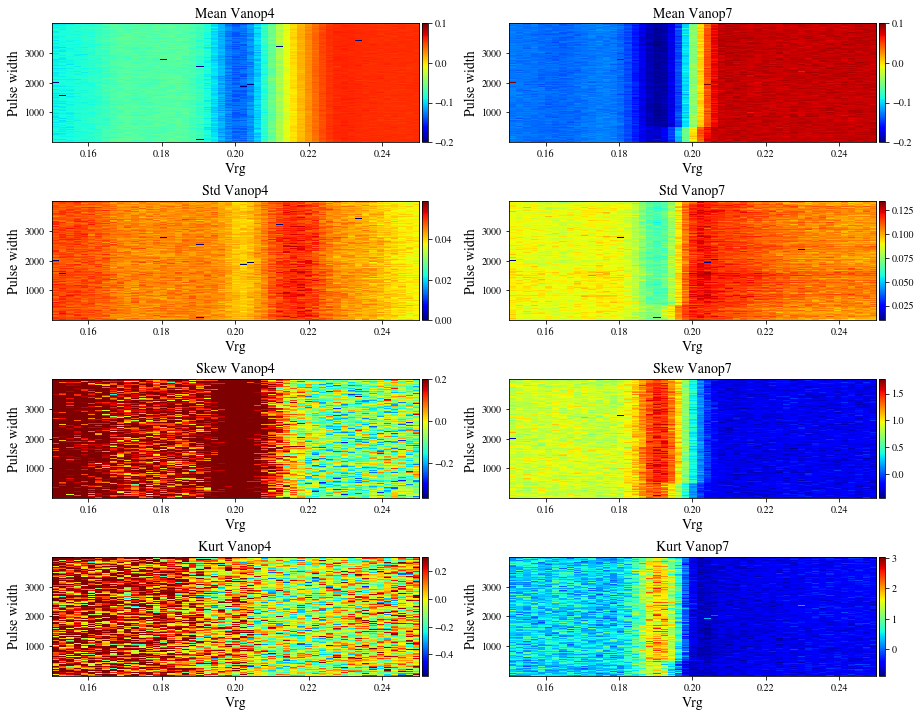

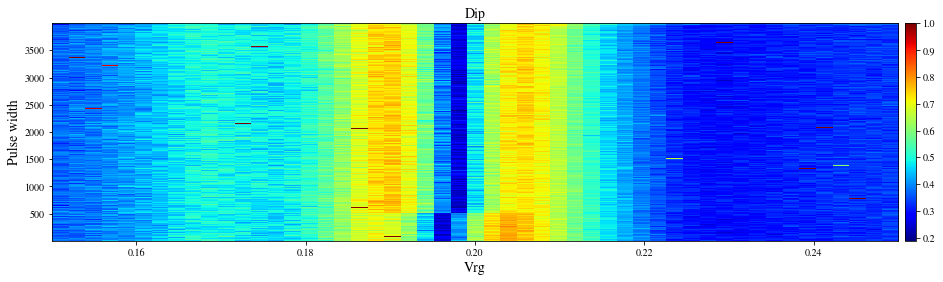

In [12]:
extent =  min(Vrg), max(Vrg), min(PW), max(PW)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,12))
# adjust the amount of width reserved for space between subplots
plt.subplots_adjust(wspace=0.05,hspace=0.5)
# fig.suptitle('Main title',fontsize = 18)

c = axs[0,0].imshow(Average4_avg_map ,extent=extent, vmin=-0.2, vmax=0.1,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[0,0],pad=0.007)
c = axs[0,1].imshow(Average7_avg_map ,extent=extent, vmin=-0.2, vmax=0.1,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[0,1],pad=0.007)
c = axs[1,0].imshow(Average4_std_map ,extent=extent, vmin=None, vmax=None,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[1,0],pad=0.007)
c = axs[1,1].imshow(Average7_std_map ,extent=extent, vmin=None, vmax=None,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[1,1],pad=0.007)

c = axs[2,0].imshow(Average4_skw_map ,extent=extent, vmin=None, vmax=0.2,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[2,0],pad=0.007)
c = axs[2,1].imshow(Average7_skw_map ,extent=extent, vmin=None, vmax=None,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[2,1],pad=0.007)

c = axs[3,0].imshow(Average4_kur_map ,extent=extent, vmin=None, vmax=0.3,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[3,0],pad=0.007)
c = axs[3,1].imshow(Average7_kur_map ,extent=extent, vmin=None, vmax=None,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[3,1],pad=0.007)


axs[0,0].set_title('Mean Vanop4', fontsize = 14)
axs[0,1].set_title('Mean Vanop7', fontsize = 14)
axs[1,0].set_title('Std Vanop4', fontsize = 14)
axs[1,1].set_title('Std Vanop7', fontsize = 14)
axs[2,0].set_title('Skew Vanop4', fontsize = 14)
axs[2,1].set_title('Skew Vanop7', fontsize = 14)
axs[3,0].set_title('Kurt Vanop4', fontsize = 14)
axs[3,1].set_title('Kurt Vanop7', fontsize = 14)


for t in axs:
    for i in range(2):
        t[i].set_xlabel('Vrg', fontsize = 14)
        t[i].set_ylabel('Pulse width', fontsize = 14)
        

        
plt.show()


fig = plt.figure(figsize=(18,4))
c=plt.imshow(Wasserstein47_map ,extent=extent, vmin=None, vmax=None,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,pad=0.007)
plt.title('Dip', fontsize = 14)
plt.xlabel('Vrg', fontsize = 14)
plt.ylabel('Pulse width', fontsize = 14)
plt.show()

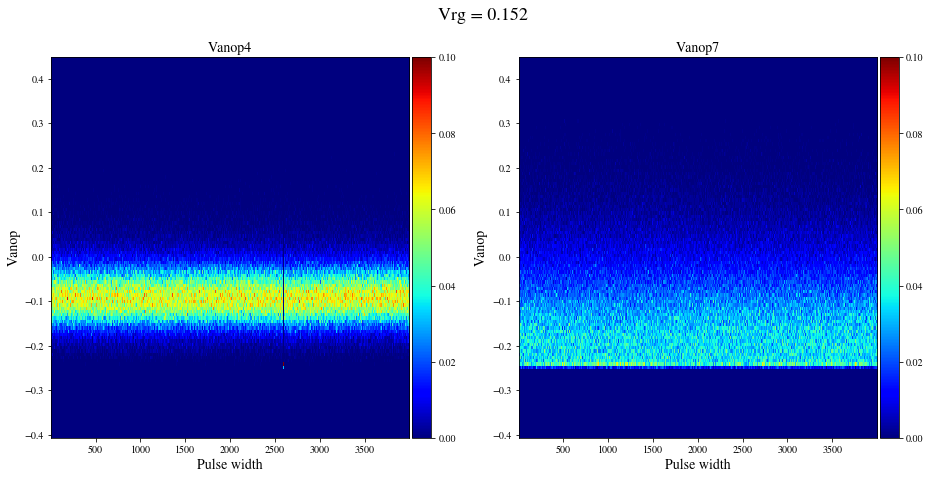

In [13]:
## Fixed Vrg
hist4 = np.reshape( histograms4, (len(PW), len(Vrg), 116) )
hist7 = np.reshape( histograms7, (len(PW), len(Vrg), 116) )
extent =  min(PW), max(PW),min(Vanop), max(Vanop)

Vrg_i = 1

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
plt.subplots_adjust(wspace=0.1,hspace=0.5)
fig.suptitle('Vrg = '+str(Vrg[Vrg_i]),fontsize = 18)
c = axs[0].imshow(hist4[:,Vrg_i,:].T ,extent=extent, vmin=0, vmax=0.1,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[0],pad=0.007)
c = axs[1].imshow(hist7[:,Vrg_i,:].T ,extent=extent, vmin=0, vmax=0.1,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
cbar = fig.colorbar(c,ax=axs[1],pad=0.007)
# axs[1].set_yticklabels([])
axs[0].set_title('Vanop4', fontsize = 14)
axs[1].set_title('Vanop7', fontsize = 14)
axs[0].set_ylabel('Vanop', fontsize = 14)
axs[0].set_xlabel('Pulse width', fontsize = 14)
axs[1].set_ylabel('Vanop', fontsize = 14)
axs[1].set_xlabel('Pulse width', fontsize = 14)

plt.show()

In [14]:
# video
hist4 = np.reshape( histograms4, (len(PW), len(Vrg), 116) )
hist7 = np.reshape( histograms7, (len(PW), len(Vrg), 116) )
extent =  min(PW), max(PW),min(Vanop), max(Vanop)






for Vrg_i in range(len(Vrg)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    fig.suptitle('Vrg = %1.3f'%Vrg[Vrg_i],fontsize = 18)
    c = axs[0].imshow(hist4[:,Vrg_i,:].T ,extent=extent, vmin=0, vmax=0.1,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
    cbar = fig.colorbar(c,ax=axs[0],pad=0.007)
    c = axs[1].imshow(hist7[:,Vrg_i,:].T ,extent=extent, vmin=0, vmax=0.1,  cmap='jet', origin='lower', filternorm =True, aspect='auto',interpolation = None)
    cbar = fig.colorbar(c,ax=axs[1],pad=0.007)
    # axs[1].set_yticklabels([])
    axs[0].set_title('Vanop4', fontsize = 14)
    axs[1].set_title('Vanop7', fontsize = 14)
    axs[0].set_ylabel('Vanop', fontsize = 14)
    axs[0].set_xlabel('Pulse width', fontsize = 14)
    axs[1].set_ylabel('Vanop', fontsize = 14)
    axs[1].set_xlabel('Pulse width', fontsize = 14)
    
    plt.savefig('./pics/%d.png'%Vrg_i, format='png', bbox_inches="tight")
    
    plt.close(fig)

files=[]
path = os.getcwd()
for i in range(51):
    file = path+'/pics/'+str(i)+'.png'
    files.append(file)

images = [imageio.imread(file) for file in files]
imageio.mimwrite('movie.gif', images, fps=10)

    


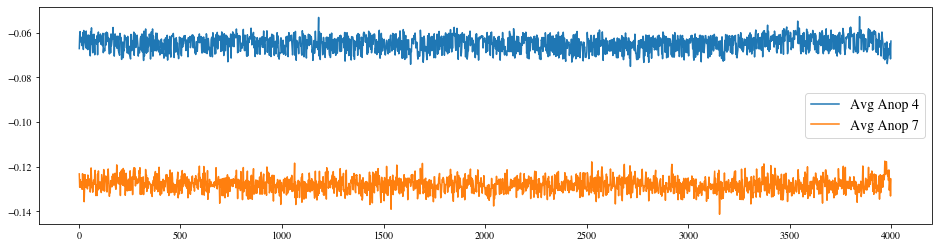

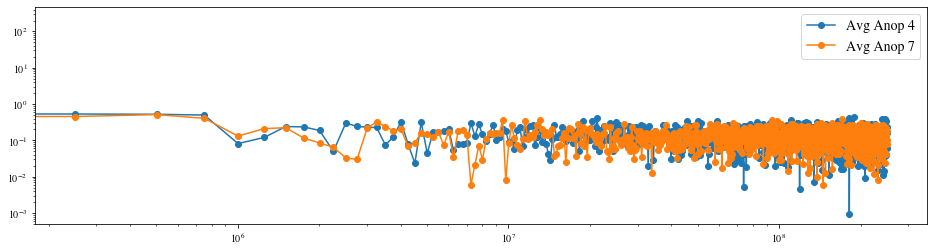

In [15]:
p = 10
x = Average4_avg_map[:,p]
y = Average7_avg_map[:,p]
thh = 5

st = 00
ed = -1

x = x[st:ed]
y = y[st:ed]

ind = np.where( (abs(x-np.mean(x))<thh*np.mean(abs(x-np.mean(x))))& (abs(y-np.mean(y))<thh*np.mean(abs(y-np.mean(y)))) )
x = x[ind]
y = y[ind]


# x=(x-np.mean(x))/np.std(x)
# y=(y-np.mean(y))/np.std(y)


plt.figure(figsize=(16,4))
plt.plot(np.linspace(PW[st],PW[ed],len(x)),x, label='Avg Anop 4')
plt.plot(np.linspace(PW[st],PW[ed],len(y)),y, label='Avg Anop 7')
plt.legend(fontsize=14)
# plt.ylim([-0.,0.11])



DURATION = max(PW)-min(PW)
SAMPLE_RATE = PW[2]-PW[1]
N = len(y)

# Number of samples in normalized_tone


# Note the extra 'r' at the front


fig= plt.figure( figsize=(16,4))
yf = rfft(x)
xf = rfftfreq(N,  SAMPLE_RATE*1E-9)
plt.plot(xf[:], np.abs(yf),'-o',label='Avg Anop 4')
yf = rfft(y)
xf = rfftfreq(N,  SAMPLE_RATE*1E-9)
plt.plot(xf[:], np.abs(yf),'-o',label='Avg Anop 7')
plt.legend(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()


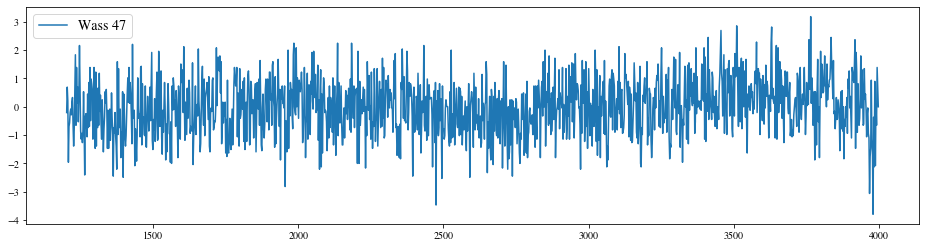

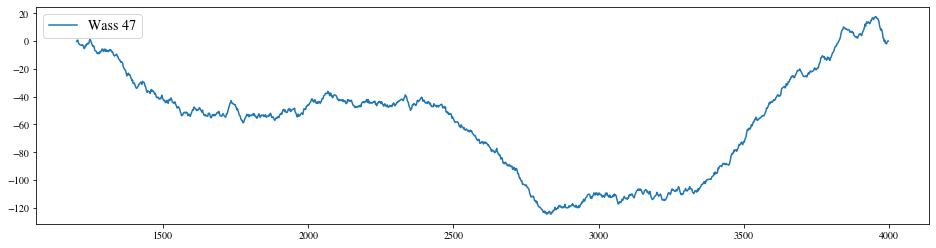

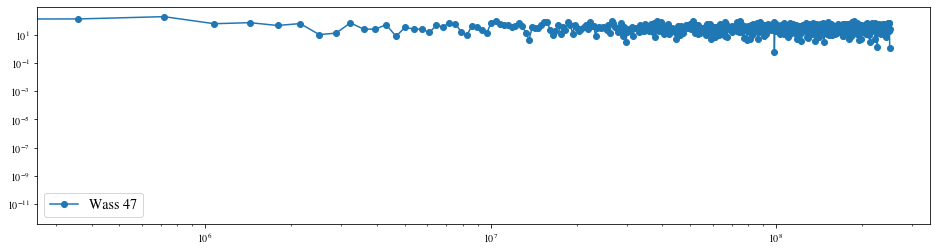

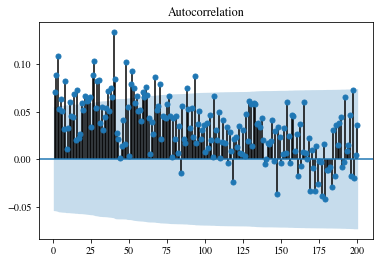

In [16]:
p = 7
x = Wasserstein47_map[:,p]

thh = 14


st = 600
ed = -1

x = x[st:ed]

ind = np.where( (abs(x-np.mean(x))<thh*np.mean(abs(x-np.mean(x)))))
x = x[ind]

x=(x-np.mean(x))/np.std(x)


plt.figure(figsize=(16,4))
plt.plot(np.linspace(PW[st],PW[ed],len(x)),x, label='Wass 47')
plt.legend(fontsize=14)
# plt.ylim([-0.,0.11])

plt.figure(figsize=(16,4))
plt.plot(np.linspace(PW[st],PW[ed],len(x)),np.cumsum(x), label='Wass 47')
plt.legend(fontsize=14) 



DURATION = max(PW)-min(PW)
SAMPLE_RATE = PW[2]-PW[1]
N = len(y)

# Number of samples in normalized_tone


# Note the extra 'r' at the front


fig= plt.figure( figsize=(16,4))
yf = rfft(x)
xf = rfftfreq(len(x),  SAMPLE_RATE*1E-9)
plt.plot(xf[:], np.abs(yf),'-o',label='Wass 47')
plt.legend(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.diff(x[1:1300],0),lags=200,zero=False)
# plt.ylim([-0.2,0.2])
plt.show()


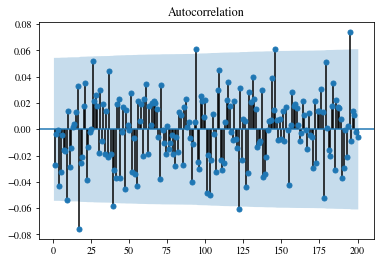

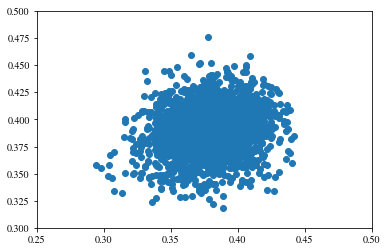

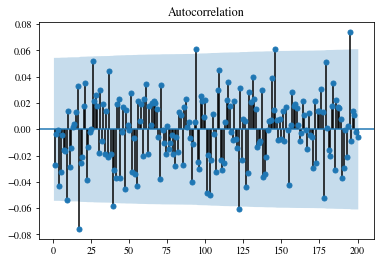

In [17]:
_=plt.plot(Wasserstein47_map[:,1],Wasserstein47_map[:,2],'o')
plt.xlim([0.25,0.5])
plt.ylim([0.3,0.5])

plot_acf(abs(np.diff(x[1:1300],0)),lags=200,zero=False)

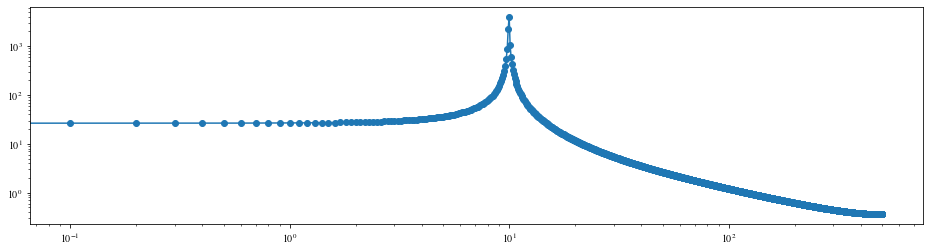

In [18]:

t = np.linspace(0,10,10000)
x = np.sin(t*6.26*10)

fig= plt.figure( figsize=(16,4))
yf = rfft(x)
xf = rfftfreq(10000,  (t[2]-t[1]))
plt.plot(xf[:], np.abs(yf),'-o',label='Avg Anop 4')
plt.yscale('log')
plt.xscale('log')
plt.show()



In [19]:

# fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
# ax1.xcorr(np.diff(x,0), np.diff(y,0), usevlines=False, maxlags=1500, normed=True)
# ax1.grid(True)

# ax2.acorr(y, usevlines=False, normed=True, maxlags=1500)
# ax2.grid(True)

# plt.show()

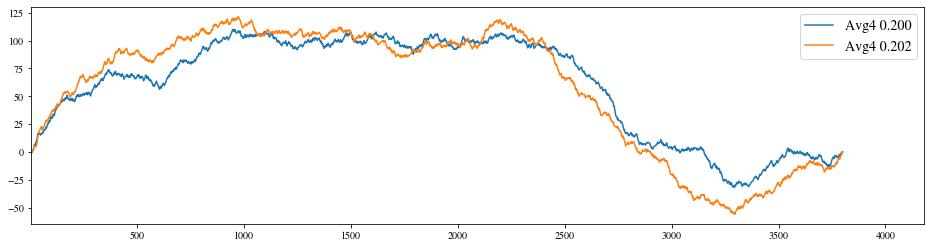

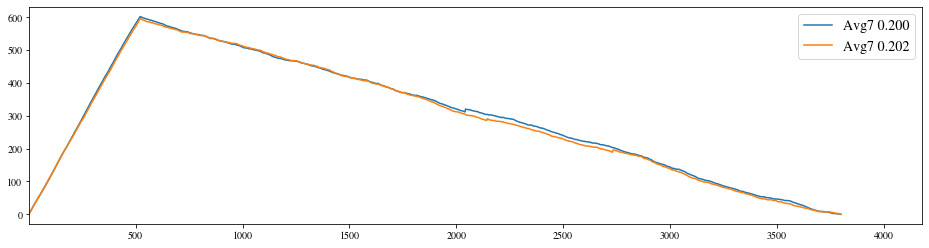

In [20]:
# thh = 14
st = 00
ed = -100
plt.figure(figsize=(16,4))


p1 = 25
p2 = 27

for p in range(p1,p2):
    x = Average4_avg_map[:,p]
    x = x[st:ed]
    ind = np.where( (abs(x-np.mean(x))<thh*np.mean(abs(x-np.mean(x)))))
    x = x[ind]
    x=(x-np.mean(x))/np.std(x)
    plt.plot(np.linspace(PW[st],PW[ed],len(x)),np.cumsum(x), label='Avg4 %1.3f'%Vrg[p])
    plt.legend(fontsize=14) 
    plt.xlim(PW[st],PW[ed]*(1.1))
plt.show()

plt.figure(figsize=(16,4))
for p in range(p1,p2):
    x = Average7_avg_map[:,p]
    x = x[st:ed]
    ind = np.where( (abs(x-np.mean(x))<thh*np.mean(abs(x-np.mean(x)))))
    x = x[ind]
    x=(x-np.mean(x))/np.std(x)
    plt.plot(np.linspace(PW[st],PW[ed],len(x)),np.cumsum(x), label='Avg7 %1.3f'%Vrg[p])
    plt.legend(fontsize=14) 
    plt.xlim(PW[st],PW[ed]*(1.1))
plt.show()


# plt.figure(figsize=(16,4))
# for p in range(p1,p2):
#     x = Wasserstein47_map[:,p]
#     x = x[st:ed]
#     ind = np.where( (abs(x-np.mean(x))<thh*np.mean(abs(x-np.mean(x)))))
#     x = x[ind]
#     x=(x-np.mean(x))/np.std(x)
#     plt.plot(np.linspace(PW[st],PW[ed],len(x)),np.cumsum(x), label='Avg7 %1.3f'%Vrg[p])
#     plt.legend(fontsize=14) 
#     plt.xlim(PW[st],PW[ed]*(1.1))
# plt.show()

